# Predicting Cardiovascular Disease
---

By: Cassie Nutter

The purpose of this notebook is to find the model that best predicts if a patient has cardiovascular disease.

This notebook follows the data science process OSEMN (Obtain, Scrub, Explore, Model, iNterpret)

### Import libraries that will be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report,\
confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve

## Obtain data
---
The data was obtained from [Kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

In [2]:
df = pd.read_csv('data/cardio_train.csv', sep= ';')

In [3]:
df.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
df.describe().T

count          mean           std      min       25%      50%  \
id           70000.0  49972.419900  28851.302323      0.0  25006.75  50001.5   
age          70000.0  19468.865814   2467.251667  10798.0  17664.00  19703.0   
gender       70000.0      1.349571      0.476838      1.0      1.00      1.0   
height       70000.0    164.359229      8.210126     55.0    159.00    165.0   
weight       70000.0     74.205690     14.395757     10.0     65.00     72.0   
ap_hi        70000.0    128.817286    154.011419   -150.0    120.00    120.0   
ap_lo        70000.0     96.630414    188.472530    -70.0     80.00     80.0   
cholesterol  70000.0      1.366871      0.680250      1.0      1.00      1.0   
gluc         70000.0      1.226457      0.572270      1.0      1.00      1.0   
smoke        70000.0      0.088129      0.283484      0.0      0.00      0.0   
alco         70000.0      0.053771      0.225568      0.0      0.00      0.0   
active       70000.0      0.803729      0.397179      0.0      1.00      1.0   
cardio       70000.0      0.499700      0.500003      0.0      0.00      0.0   

                  75%      max  
id           74889.25  99999.0  
age          21327.00  23713.0  
gender           2.00      2.0  
height         170.00    250.0  
weight          82.00    200.0  
ap_hi          140.00  16020.0  
ap_lo           90.00  11000.0  
cholesterol      2.00      3.0  
gluc             1.00      3.0  
smoke            0.00      1.0  
alco             0.00      1.0  
active           1.00      1.0  
cardio           1.00      1.0

In [6]:
df.cardio.value_counts(normalize= True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

### Data contents:

* 70,000 data points
* Almost equal counts of patients with and without cardiovascular disease
* Six continuous features, six categorical features

### Data feature descriptions:
1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code |
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

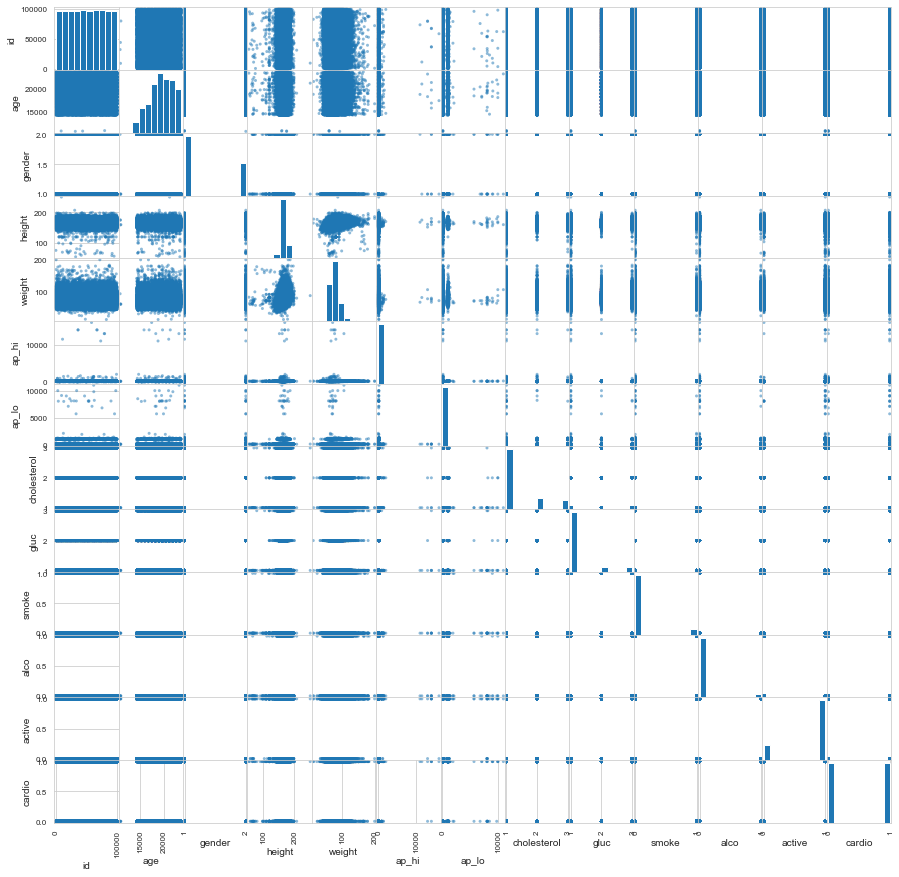

In [7]:
# scatter matrix to visualize data
pd.plotting.scatter_matrix(df, figsize = [15,15]);

## Scrub
Data cleaning

In [8]:
# Check for missing values
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [9]:
# check for duplicate values
df.duplicated().sum()

0

In [10]:
# drop id column
df.drop('id', axis= 1, inplace= True)

# change gender from 1 or 2 to 0 or 1
df['gender'].replace(2, 0, inplace= True)

# change age from days to years
df['age'] = round(df['age'] / 365, 1)

In [11]:
print(df.age.min())
df.age.max()

29.6


65.0

Our data contains adults from ages 29 - 65 years old.

Some of the heights seemed suspicious so we will check them out.

In [12]:
# check heights 
df[df['height'] < 125]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
224    59.7       0      76    55.0    120     80            1     1      0   
3420   39.8       1     100    70.0    100     70            1     1      0   
3735   48.3       1     120    70.0    120     70            1     1      0   
3752   42.2       1     120    30.0    110     70            1     1      0   
4212   44.1       1     120    80.0    120     80            1     1      0   
...     ...     ...     ...     ...    ...    ...          ...   ...    ...   
65302  50.6       1      99    60.0     90     60            1     1      0   
66023  40.0       1     120    80.0    120     70            2     1      0   
66479  46.4       0     110    90.0    110     90            1     1      0   
66643  51.6       1      57    61.0    130     90            1     1      0   
69052  55.9       0     120    80.0    140     90            1     2      0   

       alco  active  cardio  
224       0       1       0  
3420      0       1       0  
3735      0       1       0  
3752      0       1       0  
4212      0       1       0  
...     ...     ...     ...  
65302     0       1       0  
66023     0       1       0  
66479     0       1       0  
66643     0       1       1  
69052     0       1       1  

[87 rows x 12 columns]

In [13]:
# 125cm (4') seems short for the weights that are associated with them
# so we'll drop them
df = df[df['height'] >= 125]

In [14]:
df[df['height'] > 200]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
6486   58.1       1     250    86.0    140    100            3     1      0   
21628  52.2       0     207    78.0    100     70            1     1      0   

       alco  active  cardio  
6486      0       1       1  
21628     1       1       0

In [15]:
# a height of 250cm (8'2") and a weight of 86kg (190lbs) seems suspicious
df.drop(index=6486, inplace= True)

Now we will check out the odd numbers on ap_hi and ap_lo

A quick note about ap_hi and ap_lo:
Systolic and diastolic are the readings on blood pressure. 

In [16]:
# find where ap_lo is higher than ap_hi
df = df[df['ap_hi'] > df['ap_lo']]

In [17]:
# remove ap_hi and ap_lo with negative and extremely low numbers
# anything with systolic < 80 and diastolic < 50 is considered abnormally low
df = df[df['ap_hi'] > 80]
df = df[df['ap_lo'] > 50]

In [18]:
# remove any ap_hi an ap_lo readings that are abnormally high
df = df[df['ap_hi'] < 250]

In [19]:
# while these diastolic readings are very high, 
# they are still lower than the systolic and match other features
df[df['ap_lo'] > 150]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
4781   51.9       1     158    74.0    200    170            1     1      0   
4981   62.3       0     173    74.0    220    160            2     2      0   
38022  59.6       1     161    84.0    196    182            2     2      0   
43998  62.1       0     163    70.0    200    180            1     1      0   
54987  53.4       1     169    80.0    200    160            3     3      0   

       alco  active  cardio  
4781      0       1       1  
4981      0       1       1  
38022     0       1       1  
43998     0       0       1  
54987     0       1       0

Time to remove the incredibly low values for "weight"

In [20]:
#40kg = 88lbs, this would indicate a underweight person, or a typo in the data
df = df[df['weight'] >= 40]

In [21]:
# reset index
df.reset_index(inplace= True, drop= True)

In [22]:
# change feature names
new_names = {'ap_hi' : 'systolic', 
             'ap_lo' : 'diastolic', 
             'gluc' : 'glucose', 
             'alco': 'alcohol', 
             'cardio': 'disease'
            }

In [23]:
df = df.rename(columns= new_names)

In [24]:
df.shape

(68413, 12)

In [25]:
df.disease.value_counts(normalize= True)

0    0.504729
1    0.495271
Name: disease, dtype: float64

Data cleaning removed 1,488 data points from our original 70,000 and we still have an even number of patients with and without cardiovascular disease (CVD).

## Explore

### BMI analysis

Body mass index (BMI) is a measure of body fat based on height and weight that applies to adult men and women. BMI is defined as the body mass divided by the square of the body height, and is universally expressed in units of kg/m², resulting from mass in kilograms and height in meters.

In [26]:
df_eda = df.copy()

<AxesSubplot:xlabel='height', ylabel='weight'>

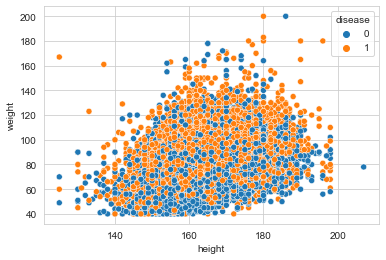

In [27]:
sns.scatterplot(x= 'height', y= 'weight', hue= 'disease', data= df_eda)

Looking at height and weight in this manner isn't very helpful.

In [28]:
# create BMI feature
def BMI (data):
    return round(data['weight'] / (data['height'] / 100) **2, 2)

df_eda['BMI'] = df_eda.apply(BMI, axis= 1)

In [29]:
df_eda.describe().T

count        mean        std     min     25%     50%     75%  \
age          68413.0   53.333130   6.759749   29.60   48.40   54.00   58.40   
gender       68413.0    0.650973   0.476666    0.00    0.00    1.00    1.00   
height       68413.0  164.450835   7.842102  125.00  159.00  165.00  170.00   
weight       68413.0   74.153387  14.259347   40.00   65.00   72.00   82.00   
systolic     68413.0  126.744961  16.620734   85.00  120.00  120.00  140.00   
diastolic    68413.0   81.366188   9.376343   52.00   80.00   80.00   90.00   
cholesterol  68413.0    1.364931   0.679155    1.00    1.00    1.00    2.00   
glucose      68413.0    1.225864   0.571804    1.00    1.00    1.00    1.00   
smoke        68413.0    0.087966   0.283247    0.00    0.00    0.00    0.00   
alcohol      68413.0    0.053396   0.224824    0.00    0.00    0.00    0.00   
active       68413.0    0.803458   0.397386    0.00    1.00    1.00    1.00   
disease      68413.0    0.495271   0.499981    0.00    0.00    0.00    1.00   
BMI          68413.0   27.455421   5.207657   13.52   23.88   26.35   30.12   

                max  
age           65.00  
gender         1.00  
height       207.00  
weight       200.00  
systolic     240.00  
diastolic    182.00  
cholesterol    3.00  
glucose        3.00  
smoke          1.00  
alcohol        1.00  
active         1.00  
disease        1.00  
BMI          106.88

![BMI chart](images/BMI.jpg)

<center> We can see that there are some BMI readings that don't make sense.

Text(0, 0.5, 'BMI')

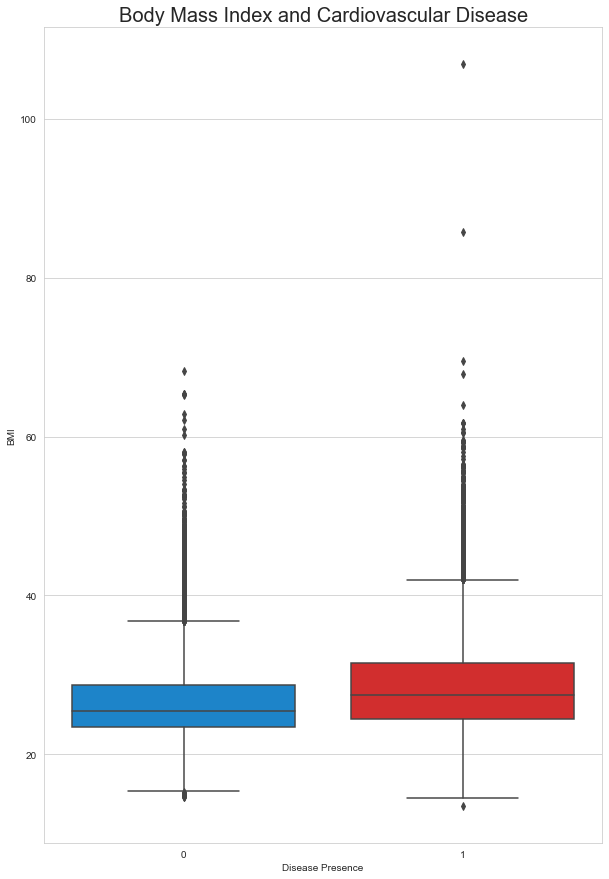

In [113]:
pal = ['#008ae6' , '#ec1313']

plt.figure(figsize= (10,15))
sns.boxplot(x = 'disease', y= 'BMI', data= df_eda, palette= pal)
plt.title('Body Mass Index and Cardiovascular Disease', fontsize= 20)
plt.xlabel('Disease Presence')
plt.ylabel('BMI')

A quick boxplot shows that individuals with CVD have, on average, higher body mass indexes than those that do not have CVD.

### Blood Pressure Category analysis

Blood pressure is the pressure of circulating blood against the walls of blood vessels. Most of this pressure results from the heart pumping blood through the circulatory system.

Here are the most recent guidelines established by the American Heart Association (as of Feb.2021)

![AHA hypertension](images/BP_chart.jpg)

In [31]:
#function to categorize blood pressure
def bp_categories(systolic, diastolic):
    if systolic > 180 or diastolic > 120:
        return 'Crisis'
    elif (140 <= systolic < 180) or (90 <= diastolic < 120):
        return 'HBP_stage2'
    elif (130 <= systolic < 140) or (80 <= diastolic < 90) :
        return 'HBP_stage1'
    elif (120 <= systolic < 130) and diastolic < 80:
        return 'Elevated'
    else:
        return 'Normal'

In [32]:
# HTN is abbreviation for hypertension
df_eda['HTN_stage'] = df_eda[['systolic', 'diastolic']].apply\
(lambda x: bp_categories(*x), axis= 1)

In [33]:
df_eda.HTN_stage.value_counts()

HBP_stage1    32429
HBP_stage2    23120
Normal         9471
Elevated       3097
Crisis          296
Name: HTN_stage, dtype: int64

Text(0, 0.5, '# of Patients')

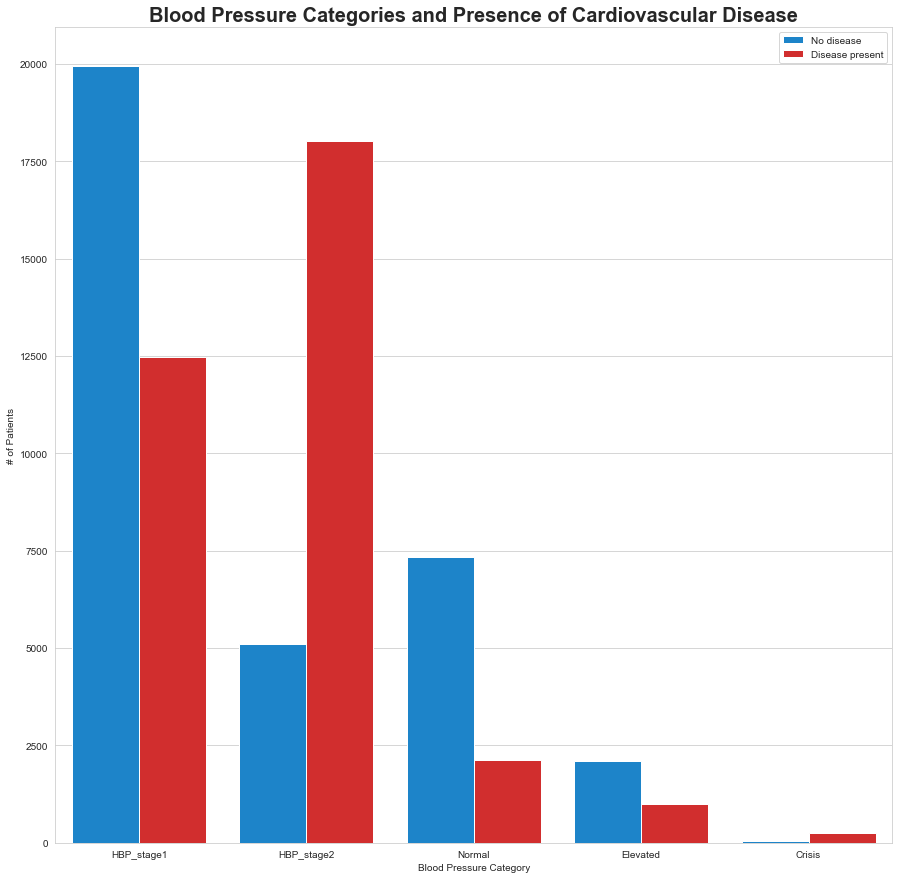

In [109]:
pal = ['#008ae6' , '#ec1313']

plt.figure(figsize= (15,15))
sns.countplot(x= 'HTN_stage', hue= 'disease', data= df_eda, palette= pal)
plt.title('Blood Pressure Categories and Presence of Cardiovascular Disease', 
          fontweight= 'bold', fontsize= 20)
plt.xlabel('Blood Pressure Category')
plt.legend( ['No disease', 'Disease present'])
plt.ylabel('# of Patients')

Groups that have a higher prevalence of cardiovascular disease have blood pressure that could be classified as Hypertension Stage 2 or Hypertensive Crisis.

The other categories, Normal, Elevated, and Hypertension Stage 1 have a higher prevalence of patients without cardiovascular disease, though it is still present.

### Age analysis

In [35]:
print(df_eda.age.min())
print(df_eda.age.max())
df_eda[df_eda['age'] < 30]

29.6
65.0


age  gender  height  weight  systolic  diastolic  cholesterol  \
6072   29.8       1     175    59.0       120         80            1   
21837  29.6       0     175    92.0       100         60            1   
29970  29.8       1     159    59.0       120         80            1   

       glucose  smoke  alcohol  active  disease    BMI   HTN_stage  
6072         1      0        0       1        0  19.27  HBP_stage1  
21837        1      0        0       1        0  30.04      Normal  
29970        1      0        0       1        0  23.34  HBP_stage1

In [36]:
# bin ages into categories
df_eda.loc[(df_eda['age'] < 40), 'age_range'] = 30
df_eda.loc[(df_eda['age'] >= 40) & (df_eda['age'] < 50), 'age_range'] = 40
df_eda.loc[(df_eda['age'] >= 50) & (df_eda['age'] < 60), 'age_range'] = 50
df_eda.loc[(df_eda['age'] >= 60) & (df_eda['age'] < 70), 'age_range'] = 60


In [37]:
df_eda.age_range.value_counts(normalize= True)

50.0    0.507082
40.0    0.278427
60.0    0.191528
30.0    0.022963
Name: age_range, dtype: float64

Text(0, 0.5, 'Patients')

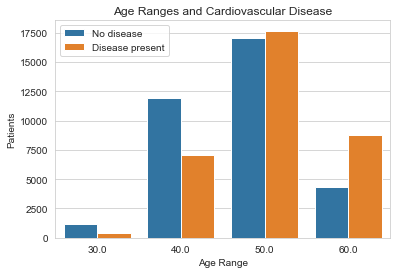

In [38]:
sns.countplot(x= 'age_range', hue= 'disease', data= df_eda)
plt.title('Age Ranges and Cardiovascular Disease')
plt.xlabel('Age Range')
plt.legend( ['No disease', 'Disease present'])
plt.ylabel('Patients')

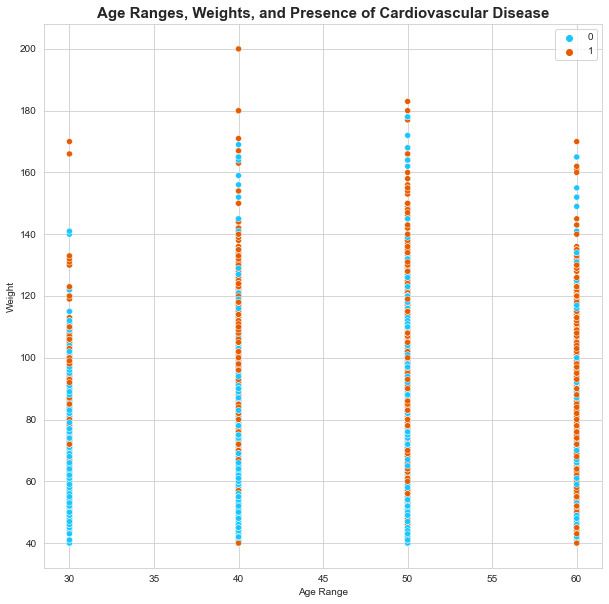

In [39]:
plt.figure(figsize= (10,10))
pal = ['#1ac6ff', '#e65c00']

sns.scatterplot(x= 'age_range', y= 'weight', hue= 'disease', data= df_eda, palette= pal)
plt.title('Age Ranges, Weights, and Presence of Cardiovascular Disease', 
          fontweight= 'bold', fontsize= 15)
plt.xlabel('Age Range')
plt.ylabel('Weight')
plt.legend()

Here we can see that as a person gets older, their chances of being diagnosed with cardiovascular disease increase. We can also see that weight doesn't really have an impact as much as age does. 

### Gender analysis

In [40]:
# determine which is male/female
df_eda.groupby('gender')['height'].mean()

gender
0    170.030279
1    161.459347
Name: height, dtype: float64

In [41]:
df_eda.groupby('gender')['weight'].mean()

gender
0    77.191369
1    72.524535
Name: weight, dtype: float64

In [42]:
df_eda.gender.value_counts(normalize= True)

1    0.650973
0    0.349027
Name: gender, dtype: float64

"0" in both analyses have the higher number. Historically, men are taller than women. We can assume that the "0" refers to male and "1" refers to females. However, it is improtant to note that the data is imbalanced (almost $1/3$ to $2/3$).

Text(0, 0.5, 'Patients')

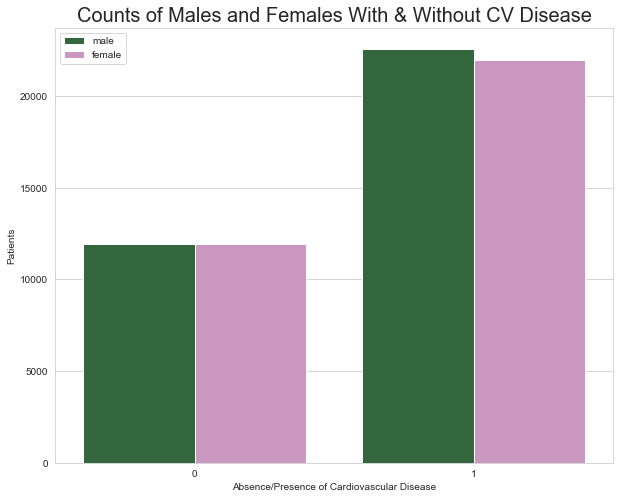

In [43]:
legend_labels = ['male', 'female']

plt.figure(figsize= (10, 8))
plt.title('Counts of Males and Females With & Without CV Disease', fontsize= 20)
sns.countplot(x= 'gender', hue= 'disease', data= df_eda, palette= 'cubehelix')
plt.xlabel('Absence/Presence of Cardiovascular Disease')
plt.legend(legend_labels)
plt.ylabel('Patients')

This graph shows that even though there is almost double the amount of women in the data, there are even amounts of disease present within each gender.

In [44]:
df_eda.groupby('gender')['disease'].mean()

gender
0    0.499832
1    0.492826
Name: disease, dtype: float64

### Other quick checks

#### Cholesterol

In [45]:
df_eda.cholesterol.value_counts(normalize= True)

1    0.749814
2    0.135442
3    0.114744
Name: cholesterol, dtype: float64

Text(0, 0.5, '# of Patients')

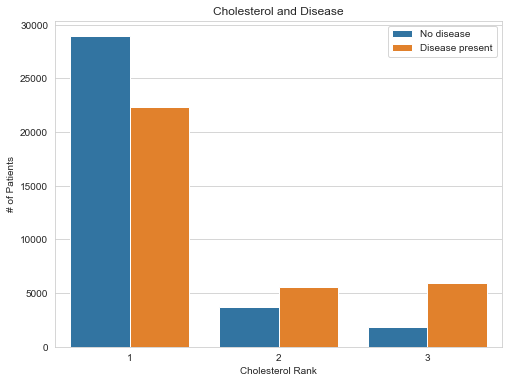

In [46]:
plt.figure(figsize= (8,6))
sns.countplot(x= 'cholesterol', hue= 'disease', data= df_eda)
plt.legend( ['No disease', 'Disease present'])
plt.title('Cholesterol and Disease')
plt.xlabel('Cholesterol Rank')
plt.ylabel('# of Patients')

Text(6.800000000000004, 0.5, 'Has Disease')

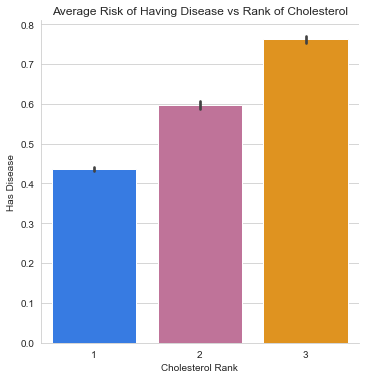

In [47]:
pal = ['#1a75ff', '#cc6699', '#ff9900']
sns.catplot(x= 'cholesterol', y= 'disease', data= df_eda, kind= 'bar', 
            palette= pal)
plt.title('Average Risk of Having Disease vs Rank of Cholesterol')
plt.xlabel('Cholesterol Rank')
plt.ylabel('Has Disease')

Having cholesterol levels "above normal" and "well above normal" increase an individuals chances of being diagnosed with cardiovascular disease. However, having "normal" cholesterol levels does not decrease your chances. There are many individuals with normal cholesterol levels and CVD.

76% of patients with cholesterol "well above normal" also have cardiovascular disease.

In [48]:
df_eda.groupby('cholesterol')['disease'].mean()

cholesterol
1    0.435971
2    0.597237
3    0.762420
Name: disease, dtype: float64

#### Activity

In [49]:
df_eda.active.value_counts(normalize= True)

1    0.803458
0    0.196542
Name: active, dtype: float64

<Figure size 1008x864 with 0 Axes>

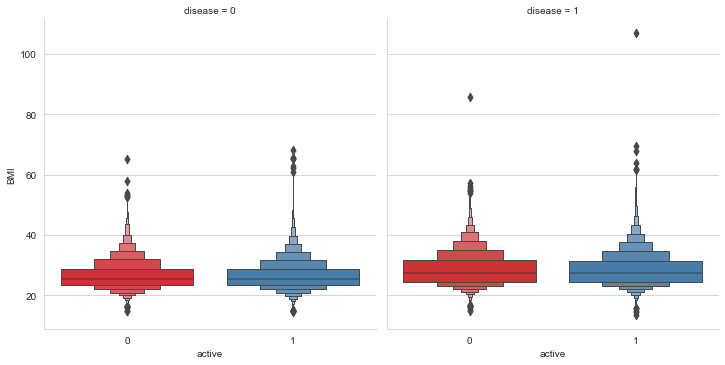

In [111]:
plt.figure(figsize= (12, 10))
sns.catplot(x='active', y='BMI', col='disease', data=df_eda, kind='boxen', 
            palette='Set1')

This visualization shows that patients without cardiovascular disease have similar body mass indexes, regardless of whether they classify themselves as active or not.

There is a slightly higher BMI for individuals that do have cardiovascular disease, but again, does not really differ if the patient is / is not active.

In [51]:
df_eda.groupby(['disease', 'active'])['BMI'].mean()

disease  active
0        0         26.521442
         1         26.460297
1        0         28.540764
         1         28.436058
Name: BMI, dtype: float64

#### Glucose

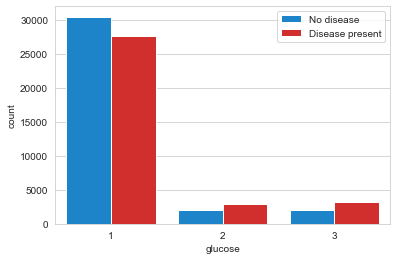

In [52]:
pal = ['#008ae6' , '#ec1313']
sns.countplot(x= 'glucose', hue= 'disease', data= df_eda, palette= pal)
plt.legend( ['No disease', 'Disease present'])

Glucose levels that are "normal" do not seem to have any relationship to having the disease or not. In fact, a patient has almost a 50% chance of having cardiovascular disease even with a normal glucose measurement. The risk of being diagnosed with cardiovascular disease increases with increasing levels of glucose.

In [53]:
df_eda.groupby('glucose')['disease'].mean()

glucose
1    0.476171
2    0.589378
3    0.617528
Name: disease, dtype: float64

#### Drink alcohol and smoke

In [54]:
df_eda.groupby(['alcohol', 'smoke'])['disease'].mean()

alcohol  smoke
0        0        0.497266
         1        0.481851
1        0        0.514054
         1        0.440377
Name: disease, dtype: float64

In [55]:
df_eda.groupby(['alcohol', 'smoke'])['disease'].count()

alcohol  smoke
0        0        60545
         1         4215
1        0         1850
         1         1803
Name: disease, dtype: int64

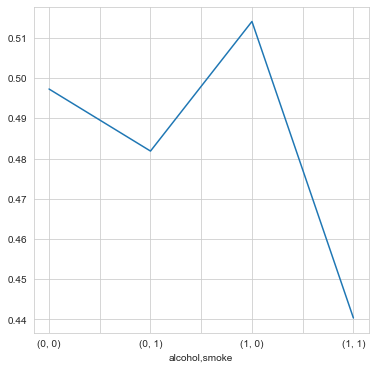

In [56]:
fig= plt.figure(figsize= (6,6))
al_smo = df_eda.groupby(['alcohol', 'smoke'])['disease'].mean().plot()

This graph shows that an individual that claims to drink alcohol and smoke has the lowest risk of being diagnosed with cardiovascular disease. However, because these features are subjective and vague (drink how much, smoke what?), it is unwise to definitively say that drinking and smoking is better for your heart.

It is also interesting that risk of having cardiovascular disease decreases when looking at drinking OR smoking. Again, this should lead one to consider subjective information to be potentially less accurate.

### Heatmap

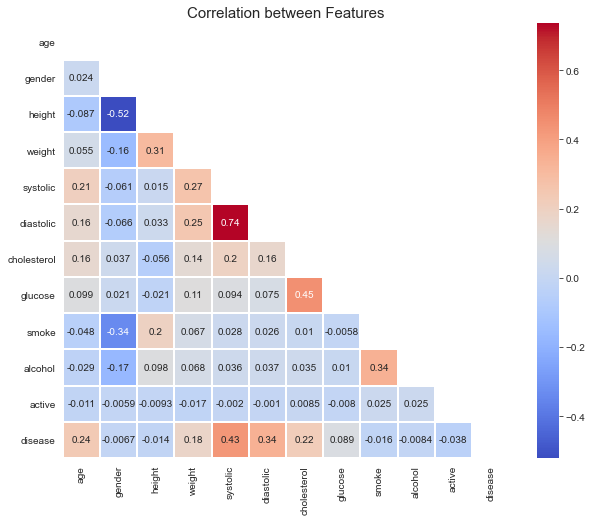

In [57]:
corr = df.corr()

plt.figure(figsize= (10,8))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1, annot= True)
plt.title('Correlation between Features', fontsize= 15)
plt.show()

The highest correlation (positive or negative) is between systolic and diastolic. The second highest is between height and gender.

The features with the highest correlation on disease are systolic, diastolic, age, and cholesterol.

## Models

### One hot encode, Split, and Standardize

In [58]:
df['cholesterol'] = df['cholesterol'].astype('category')
df['glucose'] = df['glucose'].astype('category')

In [59]:
df = pd.get_dummies(df, prefix=['chol', 'gluc'], drop_first=True)

In [60]:
y = df['disease']
X = df.drop('disease', axis= 1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [128]:
y_test.shape

(17104,)

In [62]:
scaler = StandardScaler()

In [63]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Building Models

In [64]:
classifiers = {
    'Logistic Regression' : LogisticRegression(), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'K-Nearest Neighbors' : KNeighborsClassifier(), 
    'Decision Tree' : DecisionTreeClassifier(), 
    'XGBoost' : XGBClassifier()
}

In [65]:
# takes approx 2 mins to run
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 'F1_score', 
                                'False_Negative', 'True_Positive'])

for key, value in classifiers.items():
    #fit models
    value.fit(X_train, y_train)
    train_pred = value.predict(X_train)
    y_pred = value.predict(X_test)
    
    # get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    
    # add measurements to datafram
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(f1, 2), round(FN, 0), round(TP, 0)]

In [66]:
results.sort_values(by= ['F1_score', 'False_Negative'], ascending= False)

Train_accuracy  Test_accuracy  F1_score  \
XGBoost                          76.40          72.99      0.72   
Logistic Regression              72.84          72.81      0.71   
Support Vector Machine           73.78          73.22      0.71   
Random Forest                    99.55          70.98      0.70   
K-Nearest Neighbors              78.39          69.07      0.69   
Decision Tree                    99.55          63.40      0.63   

                        False_Negative  True_Positive  
XGBoost                         2651.0         5811.0  
Logistic Regression             2827.0         5635.0  
Support Vector Machine          2790.0         5672.0  
Random Forest                   2575.0         5887.0  
K-Nearest Neighbors             2695.0         5767.0  
Decision Tree                   3176.0         5286.0

We got decent results without any hyperparameter tuning. We can do that next to see if we can improve the accuracy and decrease the overfitting.

### Hyperparameter Tuning

In [67]:
# function to get results after each model

def get_results(model, model_name):
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # get classification report
    print('{} Classification Report'.format(model_name))
    print(classification_report(y_test, y_pred))
    
    # get confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap= "Blues", values_format= '.5g')
    plt.grid(False)
    plt.show()
    
    # get accuracy and F1 scores
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    
    # save measurements into results df
    results.loc[model_name] = [round(train_acc, 2), round(test_acc, 2), 
                               round(f1, 2), round(FN, 0), round(TP, 0)]

#### XGBoost 

In [68]:
# Instantiate classifier
xgb = XGBClassifier()

In [69]:
# create hyperparameter grid
param_grid_xgb = {
    'learning_rate': [0.08],
    'max_depth': [4],
    'min_child_weight': [2, 3],
    'n_estimaters' : [125, 150],
    'scale_pos_weight' : [1.5, 1.7]
}

# Instantiate Randomized Search
# n_jobs : Number of jobs to run in parallel. -1 means using all processors.
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, n_jobs= 3, scoring= 'recall', 
                            random_state=42)

In [70]:
# fit model
# approx 1 min to run
RS_xgb.fit(X_train, y_train)

[15:53:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=

In [71]:
RS_xgb.best_params_

{'scale_pos_weight': 1.7,
 'n_estimaters': 125,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.08}

RS XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.77      0.62      0.68      8642
           1       0.67      0.81      0.74      8462

    accuracy                           0.71     17104
   macro avg       0.72      0.71      0.71     17104
weighted avg       0.72      0.71      0.71     17104



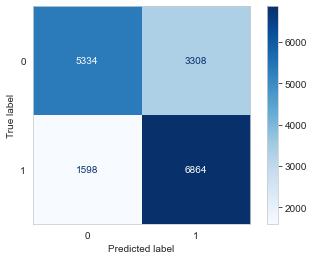

In [72]:
# see model results and add to results df
get_results(RS_xgb, 'RS XGBoost')

#### Random Forest

In [73]:
# Instantiate classifier
RF = RandomForestClassifier()

In [74]:
param_grid_RF = {
    'n_estimators' : [200],
    'max_depth' : [100], 
    'min_samples_split' : [5, 8], 
    'min_samples_leaf' : [3],
    'class_weight' : [{1 : 1.5}, {1 : 1.7}]
}

# Instantiate Randomized Search
RS_RF = RandomizedSearchCV(RF, param_grid_RF, n_iter= 20, scoring= 'recall', 
                           random_state= 42)

In [75]:
# fit model
# approx 2 mins to run
RS_RF.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'class_weight': [{1: 1.5}, {1: 1.7}],
                                        'max_depth': [100],
                                        'min_samples_leaf': [3],
                                        'min_samples_split': [5, 8],
                                        'n_estimators': [200]},
                   random_state=42, scoring='recall')

In [76]:
RS_RF.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 100,
 'class_weight': {1: 1.7}}

RS Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      8642
           1       0.69      0.78      0.73      8462

    accuracy                           0.72     17104
   macro avg       0.72      0.72      0.72     17104
weighted avg       0.72      0.72      0.72     17104



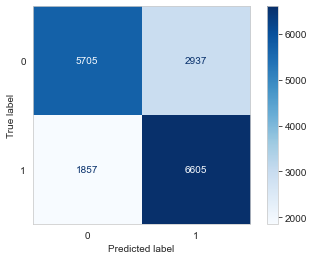

In [77]:
# see model results and add to results df
get_results(RS_RF, 'RS Random Forest')

#### K-Nearest Neighbor

In [78]:
# Instantiate classifier
KNN = KNeighborsClassifier()

In [79]:
# set parameter guidelines
param_grid_KNN = {
    'n_neighbors' : [23, 25, 27], 
    'weights' : ['uniform', 'distance']
}

# Instantiate Grid Search
GS_KNN = GridSearchCV(KNN, param_grid_KNN, n_jobs= 3, scoring= 'recall')

In [80]:
# fit model
# approx 1 min to run
GS_KNN.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'n_neighbors': [23, 25, 27],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [81]:
GS_KNN.best_params_

{'n_neighbors': 23, 'weights': 'distance'}

GS KNN Classification Report
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      8642
           1       0.72      0.69      0.71      8462

    accuracy                           0.72     17104
   macro avg       0.72      0.72      0.72     17104
weighted avg       0.72      0.72      0.72     17104



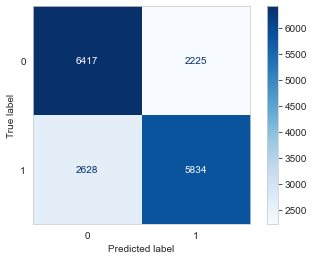

In [82]:
# see model results and add to results df
get_results(GS_KNN, 'GS KNN')

#### Support Vector Machines

In [83]:
# Instantiate classifier
svc = SVC(class_weight = {1: 1.5}, random_state= 42)

In [84]:
# fit model
# approx 2 mins to run
svc.fit(X_train, y_train)

SVC(class_weight={1: 1.5}, random_state=42)

Tuned SVM Classification Report
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      8642
           1       0.70      0.78      0.73      8462

    accuracy                           0.72     17104
   macro avg       0.73      0.72      0.72     17104
weighted avg       0.73      0.72      0.72     17104



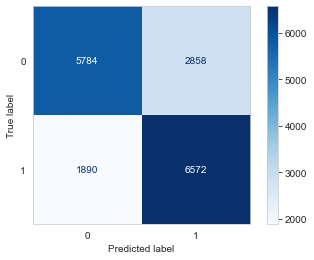

In [85]:
# see model results and add to results df
get_results(svc, 'Tuned SVM')

#### Logistic Regression

In [86]:
# Instantiate classifier
LG = LogisticRegression()

In [87]:
# set parameter criteria
param_grid_LG = {
    'penalty': ['l1', 'l2'],
    'C':[0.05, 0.1, 1], 
    'class_weight' : [None, {1 : 1.5}], 
    'random_state' : [42]
}

# Instantiate Grid Search
GS_LG = GridSearchCV(LG, param_grid_LG, scoring= 'recall')

In [88]:
# fit model
# approx 1 sec to run
GS_LG.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.05, 0.1, 1], 'class_weight': [None, {1: 1.5}],
                         'penalty': ['l1', 'l2'], 'random_state': [42]},
             scoring='recall')

In [89]:
GS_LG.best_params_

{'C': 0.05, 'class_weight': {1: 1.5}, 'penalty': 'l2', 'random_state': 42}

GS Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.76      0.64      0.69      8642
           1       0.68      0.79      0.73      8462

    accuracy                           0.71     17104
   macro avg       0.72      0.71      0.71     17104
weighted avg       0.72      0.71      0.71     17104



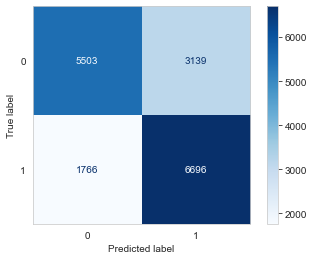

In [90]:
# see model results and add to results df
get_results(GS_LG, 'GS Logistic Regression')

#### Decision Tree

In [91]:
# Instantiate classifier
DT = DecisionTreeClassifier()

In [92]:
# set parameter criteria
param_grid_DT = {
    'max_depth' : [3, 4, 5], 
    'min_samples_split' : [0.01, 0.05, 0.1], 
    'min_samples_leaf' : [5, 7], 
    'class_weight' : [{1 : 1.4}, {1 : 1.6}]
}

# Instantiate Randomized Search
RS_DT = RandomizedSearchCV(DT, param_grid_DT, n_jobs= 3, random_state=42)

In [93]:
# approx 1 sec to run
RS_DT.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=3,
                   param_distributions={'class_weight': [{1: 1.4}, {1: 1.6}],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_leaf': [5, 7],
                                        'min_samples_split': [0.01, 0.05, 0.1]},
                   random_state=42)

In [94]:
RS_DT.best_params_

{'min_samples_split': 0.05,
 'min_samples_leaf': 5,
 'max_depth': 5,
 'class_weight': {1: 1.4}}

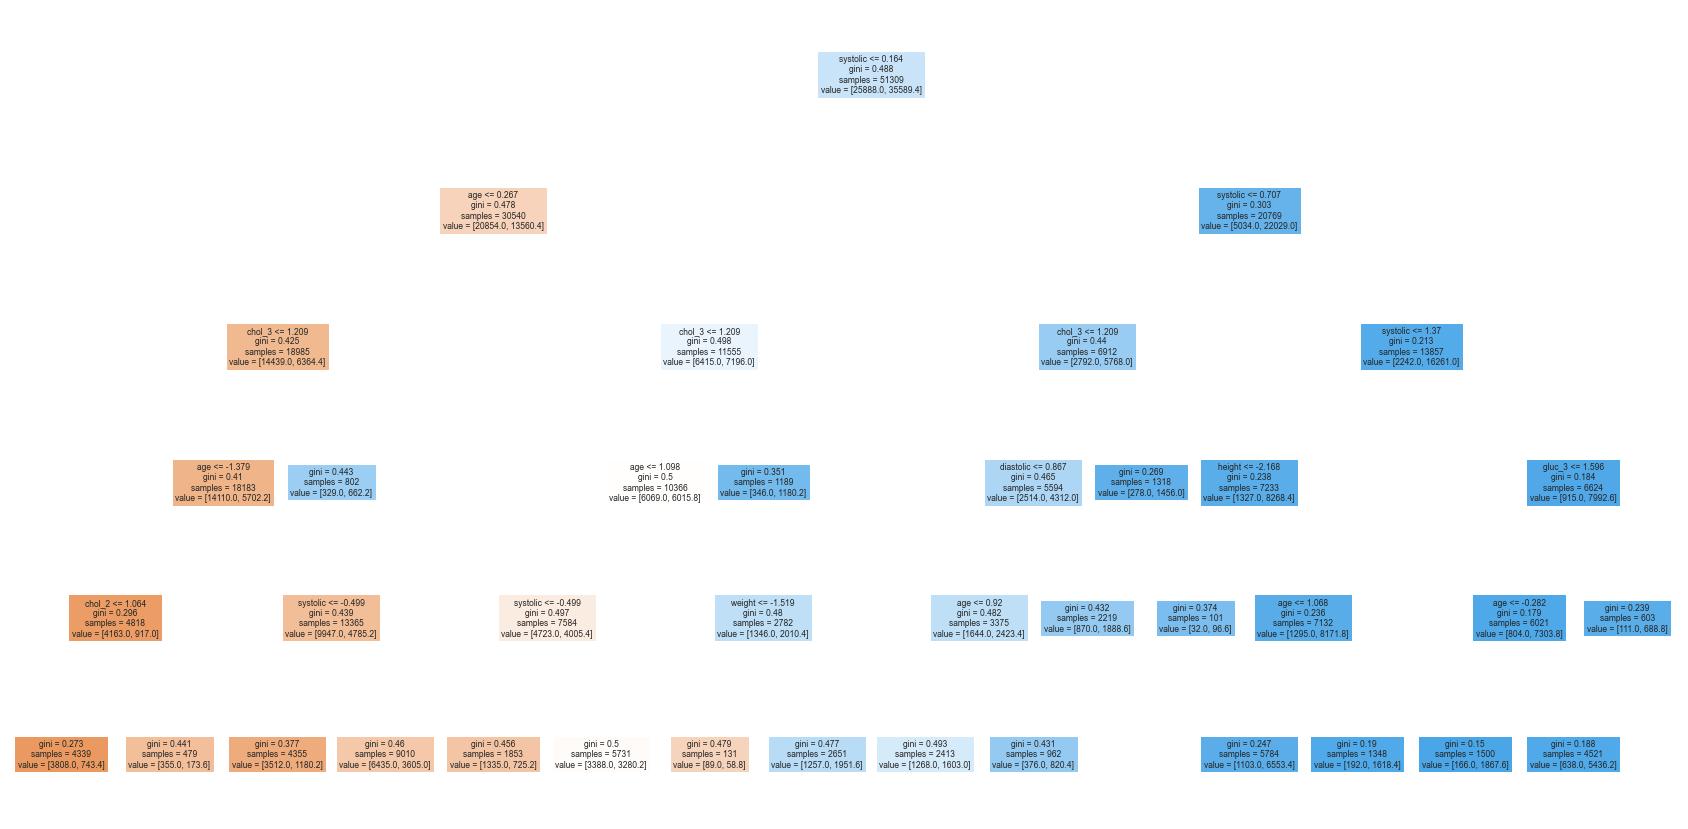

In [95]:
plt.figure(figsize= (30,15))
_ = tree.plot_tree(RS_DT.best_estimator_ , feature_names = X.columns, filled= True) 

RS Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8642
           1       0.73      0.73      0.73      8462

    accuracy                           0.73     17104
   macro avg       0.73      0.73      0.73     17104
weighted avg       0.73      0.73      0.73     17104



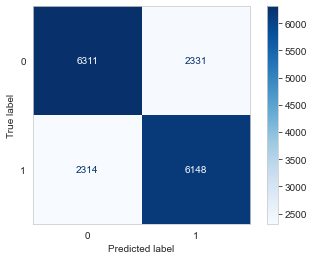

In [96]:
get_results(RS_DT, 'RS Decision Tree')

## Interpret

### Results
Now, let's take the time to look in depth at some of the best results we achieved.

In [97]:
# view all results
results = results.sort_values(by= ['F1_score', 'False_Negative'], 
                              ascending= False)
results

Train_accuracy  Test_accuracy  F1_score  \
RS XGBoost                       72.07          71.32      0.74   
RS Decision Tree                 72.83          72.84      0.73   
Tuned SVM                        73.02          72.24      0.73   
RS Random Forest                 81.86          71.97      0.73   
GS Logistic Regression           71.53          71.32      0.73   
XGBoost                          76.40          72.99      0.72   
Logistic Regression              72.84          72.81      0.71   
Support Vector Machine           73.78          73.22      0.71   
GS KNN                           99.55          71.63      0.71   
Random Forest                    99.55          70.98      0.70   
K-Nearest Neighbors              78.39          69.07      0.69   
Decision Tree                    99.55          63.40      0.63   

                        False_Negative  True_Positive  
RS XGBoost                      1598.0         6864.0  
RS Decision Tree                2314.0         6148.0  
Tuned SVM                       1890.0         6572.0  
RS Random Forest                1857.0         6605.0  
GS Logistic Regression          1766.0         6696.0  
XGBoost                         2651.0         5811.0  
Logistic Regression             2827.0         5635.0  
Support Vector Machine          2790.0         5672.0  
GS KNN                          2628.0         5834.0  
Random Forest                   2575.0         5887.0  
K-Nearest Neighbors             2695.0         5767.0  
Decision Tree                   3176.0         5286.0

Since we are looking at medical data, missing a diagnosis of cardiovascular disease could be deadly. But we had to weigh that against misdiagnosing too many people that don't have the disease and telling them to get a bunch of expensive tests. We also didn't want to hurt the accuracy of the prediction, so we walked a fine line. 

That is why looking at F1 score (conveys the balance between the precision and the recall) and false negatives are so important to this prediction.

We can see that the tuned XGBoost was able to predict the most True Positive and fewest false negatives. It has the highest F1 score and testing and training accuracy are very similar suggesting no overfitting.

The tuned decision tree had the most improvement and train/test accuracies are almost equal, but it is one of the worst tuned models with regards to false negatives (misclassified 700 more than tuned XGBoost)

### Test Accuracy

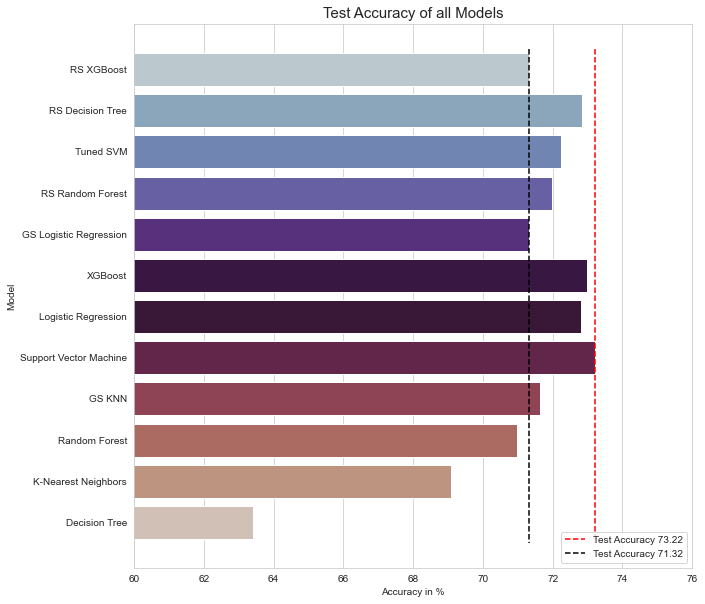

In [98]:
# see results in bar graph
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x= results['Test_accuracy'], y= results.index, palette = 'twilight')
plt.vlines(x = 73.22, ymin = -.5, ymax = 11.5, linestyle= 'dashed', 
           color = 'r', label= 'Test Accuracy 73.22')
plt.vlines(x = 71.32, ymin = -.5, ymax = 11.5, linestyle= 'dashed', 
           color = 'black', label= 'Test Accuracy 71.32')
plt.title('Test Accuracy of all Models', fontsize= 15)
plt.ylabel('Model')
plt.xlabel('Accuracy in %')
plt.xlim(60, 76)
ax.legend(loc = 'lower right')

The highest accuracy score is at 73.22% by the untuned support vector machine model. The tuned XGBoost model's test accuracy is 71.32% - which happens to be the same as the tuned logistic regression.

### ROC Curve 

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 

Text(0, 0.5, 'True Positive Rate')

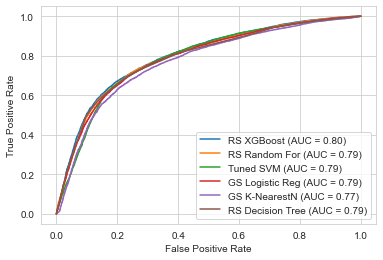

In [99]:
#ROC curve of best 6 models
fig = plot_roc_curve(RS_xgb, X_test, y_test, name= 'RS XGBoost')
plot_roc_curve(RS_RF,X_test, y_test, ax = fig.ax_, name= 'RS Random For')
plot_roc_curve(svc,X_test, y_test, ax = fig.ax_, name= 'Tuned SVM')
plot_roc_curve(GS_LG,X_test, y_test, ax = fig.ax_, name= 'GS Logistic Reg')
plot_roc_curve(GS_KNN,X_test, y_test, ax = fig.ax_, name= 'GS K-NearestN')
plot_roc_curve(RS_DT,X_test, y_test, ax = fig.ax_, name= 'RS Decision Tree')

# fig.figure.suptitle('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

While most of the tuned models perform similarly, the tuned XGBoost again slightly outperforms the other models.

### Feature Importance

Let's take a look at the tuned XGBoost and see which features were the most important to our model.

In [100]:
# create DataFrame with feature importance to create nice looking graph
#  using tuned XGBoost model
FeatImp={'feature_names' : X.columns.values, 
         'feature_importance' : RS_xgb.best_estimator_.feature_importances_}
FI_df = pd.DataFrame(FeatImp)
FI_df.sort_values(by= ['feature_importance'], ascending= False, inplace= True)

Text(0, 0.5, 'Feature')

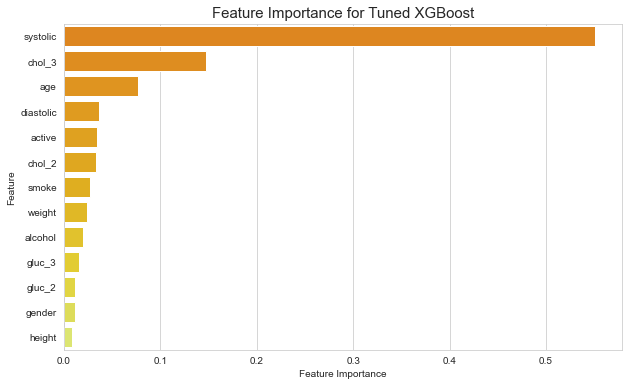

In [112]:
# plot new DataFrame
plt.figure(figsize= (10,6))
sns.barplot(x= FI_df['feature_importance'], y= FI_df['feature_names'], 
            palette= 'Wistia_r')
plt.title('Feature Importance for Tuned XGBoost', fontsize= '15')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

In [117]:
FI_df

feature_names  feature_importance
4       systolic            0.550979
10        chol_3            0.147816
0            age            0.077396
5      diastolic            0.036565
8         active            0.034227
9         chol_2            0.033218
6          smoke            0.027517
3         weight            0.023779
7        alcohol            0.020120
12        gluc_3            0.016102
11        gluc_2            0.011886
1         gender            0.011811
2         height            0.008583

The systolic reading is by far the most important feature in predicting cardiovascular disease. Having a cholesterol well above normal, and a person's age are the second and third most important features, respectively.

Activity is the highest subjective feature, followed closely by smoking as the next subjective feature.

### Conclusion

The model that performed the best overall was XGBoost with tuned hyperparameters. 

Due to it's highest false negative and true positive rates as well as the highest F1 score. It may not have been the most accurate model that was made, but was fairly close (by less than 2%). This model also had the highest AUC (Area Under the Curve) score showing us it was the most accurate.

From the model, we can conclude that having a low blood pressure, low cholesterol, being young, and being active are the best ways to avoid cardiovascular disease.